## ***`Spanish Dataset`***

TASS was the first shared task on sentiment analysis in Twitter in Spanish. This dataset consists in tweets extracted from the different subsets of Spain, Peru, Costa Rica, Chile, Uruguay, and Mexico. 

The dataset is based on events that occurred in April 2019, amongst all, entertainment, political, global commemoration, and global strike events. Hashtags and user mentions are already transformed into keywords: “HASHTAG” and "@USER" because these events are polarized.

This dataset http://tass.sepln.org/2020/ contains a total of 8,409 tweets written in Spanish however not every catagory is of our interest where train, validation and test are already split up for us http://tass.sepln.org/2020/?page_id=74 .

In [ ]:
#Importing data

import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing libraries
import numpy as np 
import pandas as pd 

import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

### ***Preprocessing***

We will join validation and train sets, to make the preprocessing at the same time.

In [ ]:
df2  = pd.read_csv("/content/drive/MyDrive/train.tsv", sep='\t')
display(df2.head())

,id,tweet,label
0,1,El Atlético resignado a perder HASHTAG 😔 http...,sadness
1,2,Leer proporciona una mejor visión del mundo 🤓 ...,joy
2,3,Amo a Arya Stark por encima de todas las cosas...,joy
3,4,Gracias HASHTAG es increíble que una niña logr...,others
4,5,Solo siento que hayamos perdido 24 escaños de ...,sadness


**Dive deep into dataframe**

In [ ]:
df2.columns

Index(['id', 'tweet', 'label '], dtype='object')

In [ ]:
df2 = df2.rename({'label ': 'label'}, axis=1) #Rename the column label

Removing "others" and "disgust" category from list

In [ ]:
df2 = df2[~df2.label.str.contains("others")]
df2 = df2[~df2.label.str.contains("disgust")]
df2['label'].value_counts()

joy          1270
sadness       706
anger         600
surprise      241
fear           67
Name: label, dtype: int64

Plot the dataset

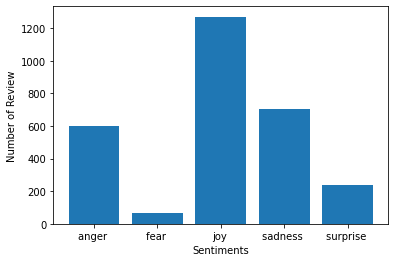

In [ ]:
dataframe2=df2.groupby('label').count()
plt.bar(dataframe2.index.values, dataframe2['tweet'])
plt.xlabel('Sentiments')
plt.ylabel('Number of Review')
plt.show()

A quick look onto the length of the tweets of the dataset.

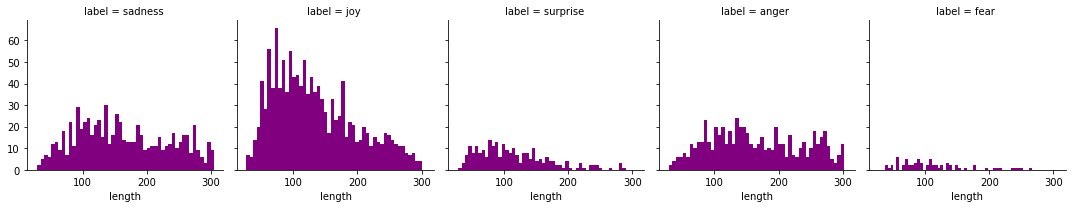

In [ ]:
df2.describe(include='all')
df2['length'] = df2['tweet'].apply(len)
df2.head()
graph = sns.FacetGrid(data=df2,col='label')
graph.map(plt.hist,'length',bins=50,color='Purple')

Re-doing the process with validation file.

In [ ]:
df1  = pd.read_csv("/content/drive/MyDrive/dev.tsv", sep='\t')
display(df1.head())

,id,tweet,label
0,1,-Spoiler- Nadie ha tenido el dilema de tener q...,others
1,2,Yo solo quiero saber donde esta HASHTAG? HASHT...,others
2,3,"La literatura nos hace más empáticos, dispuest...",joy
3,4,"Para mi, estas son las 4 mejores escenas de es...",surprise
4,5,Lo que acabo de ver es puro oro. Historia de l...,joy


In [ ]:
df1 = df1.rename({'label ': 'label'}, axis=1) #Renaming column name 

Removing "others" and "disgust" category from list

In [ ]:
df1 = df1[~df1.label.str.contains("others")]
df1 = df1[~df1.label.str.contains("disgust")]
df1['label'].value_counts()

joy          185
sadness      103
anger         87
surprise      35
fear          10
Name: label, dtype: int64

Plot the dataset

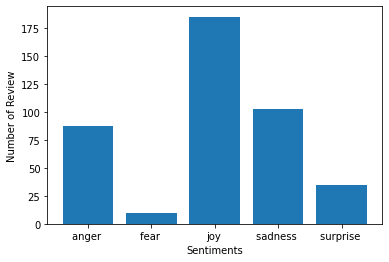

In [ ]:
dataframe1=df1.groupby('label').count()
plt.bar(dataframe1.index.values, dataframe1['tweet'])
plt.xlabel('Sentiments')
plt.ylabel('Number of Review')
plt.show()

A quick look onto the length of the tweets of the dataset.

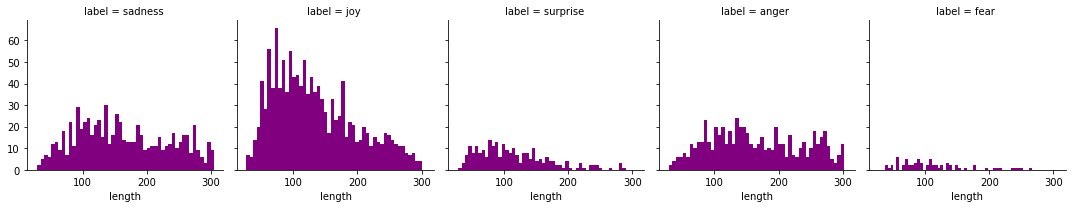

In [ ]:
df1.describe(include='all')
df1['length'] = df2['tweet'].apply(len)
df1.head()
graph = sns.FacetGrid(data=df2,col='label')
graph.map(plt.hist,'length',bins=50,color='Purple')

Merging both datasets so preprocessing is smooth.

In [ ]:
df = pd.concat([df2, df1], ignore_index=True)
display(df.head())

,id,tweet,label,length
0,1,El Atlético resignado a perder HASHTAG 😔 http...,sadness,65.0
1,2,Leer proporciona una mejor visión del mundo 🤓 ...,joy,98.0
2,3,Amo a Arya Stark por encima de todas las cosas...,joy,72.0
3,5,Solo siento que hayamos perdido 24 escaños de ...,sadness,61.0
4,6,Solo con ver con la intensidad que agitan las ...,joy,177.0


In [ ]:
df['label'].value_counts()

joy          1455
sadness       809
anger         687
surprise      276
fear           77
Name: label, dtype: int64

As we have seen, the dataset has a class imbalance. An imbalanced dataset in NLP is a dataset whose number of data samples is not the same in the different classes. One class has more data samples than the other class. When we train a model with an imbalanced dataset, the model will be biased towards the majority class. The model may make wrong predictions and give inaccurate results. It has a negative impact when we use the model in production, and the stakeholders depend on it for business operations.We will use the Imbalanced-learn library. This library will balance the classes in the dataset. It will also reduce model bias and enhance the NLP performance.

Additionally, we are redoing the id column so it is linear.

In [ ]:
df["ID"] = df.index + 1
df.drop('id', axis=1, inplace=True)

In [ ]:
df.drop('length', axis=1, inplace=True)

#### ***Preprocessing***

The dataset has 3304 data samples (rows) and 3 columns.

In [ ]:
df.shape

(3304, 3)

Check for null values if exist.

In [ ]:
df.isnull().sum()

tweet    0
label    0
ID       0
dtype: int64

We will calculate the length of each data sample by creating a new column that will show the length of each data sample. This new column will help us with preprocessing the data samples.

In [ ]:
df['length'] = df['tweet'].apply(lambda x: len(x))
display(df.head())

,tweet,label,ID,length
0,El Atlético resignado a perder HASHTAG 😔 http...,sadness,1,65
1,Leer proporciona una mejor visión del mundo 🤓 ...,joy,2,98
2,Amo a Arya Stark por encima de todas las cosas...,joy,3,72
3,Solo siento que hayamos perdido 24 escaños de ...,sadness,4,61
4,Solo con ver con la intensidad que agitan las ...,joy,5,177


#### ***Text cleaning***

We will clean the dataset by removing unnecessary words, punctuation, stop words, white spaces, and unnecessary symbols from the text dataset.

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk

NLTK has smaller sub-libraries that perform specific text cleaning tasks. These smaller libraries also have methods for text cleaning.

The next step is to download the smaller sub-libraries from NLTK as follows:

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We will create custom functions for text cleaning and pass in the imported methods as parameters. To implement the custom functions, we will require Python regular expression (RegEx) module and string module.

In [ ]:
import re,string

In [ ]:
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

In [ ]:
def strip_all_entities(text):
    entity_prefixes = ['@','#', '¿', '¡']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: strip_links(x))

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: strip_all_entities(x))

We need to remove users and hashtags in a specific way they do not add to our analysis.

In [ ]:
df['tweet'] = df['tweet'].str.replace(r'HASHTAG', '', regex=True)
df['tweet'] = df['tweet'].str.replace(r'USER', '', regex=True)

Create a function for converting the text to lower case. Converting all tweets to lower case to ensure that we have a uniform dataset.

In [ ]:
def convert_to_lower(text):
    return text.lower()

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: convert_to_lower(x))

Removing numbers and other numeric values function to ensure that only text that remains in the dataset adds value to the model.

In [ ]:
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: remove_numbers(x))

Removing punctuations function: full stops and other punctuation marks, these are unnecessary symbols in the dataset.

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: remove_punctuation(x))

Removing stop words function

In [ ]:
from nltk import word_tokenize #method that will perform text tokenization.

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopword_es = nltk.corpus.stopwords.words('spanish')
stopword = stopword_es

def remove_stopwords(text):
    removed = []
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stopword:
            removed.append(tokens[i])
    return " ".join(removed)

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: remove_stopwords(x))

Remove extra white spaces function. White space occupies the dataset, but they do not carry information. Removing the extra white spaces ensures we only remain with the text that the model will use.

In [ ]:
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: remove_extra_white_spaces(x))

Removing emojis, by removing them it ensures we only remain with the text that the model will use.

In [ ]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import emoji

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                    u"\U0001F600-\U0001F64F" #emoticons
                    u"\U0001F300-\U0001F5FF" #symbols and pictographs
                    u"\U0001F680-\U0001F6FF" #transport and map symbols
                    u"\U0001F1E0-\U0001F1FF" #flags (ios)
                    u"\U00002702-\U000027B0" 
                    u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: remove_emoji(x))

In [ ]:
pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from cleantext import clean
df['tweet'] = df['tweet'].apply(lambda x: clean(x, no_emoji = True))

In [ ]:
pd.set_option('display.max_columns', None)
df

,tweet,label,ID,length
0,atletico resignado perder,sadness,1,65
1,leer proporciona mejor vision mundo,joy,2,98
2,amo arya stark encima todas cosas gameofthrones,joy,3,72
3,solo siento perdido escanos cordura,sadness,4,61
4,solo ver intensidad agitan banderas ve quedado...,joy,5,177
...,...,...,...,...
3299,dilatacion mentiras basta creer pueblo sigue s...,anger,3300,234
3300,iba decir enfrentarian incendio gracias luchar...,joy,3301,208
3301,gracias dios ocurrio menos malo,joy,3302,45
3302,messi mejor tiempos extraterrestre,joy,3303,111


Calculating the length of each data sample after performing text cleaning

In [ ]:
df['length_after_cleaning'] = df['tweet'].apply(lambda x: len(x))

Converting the class labels into integer values.

The class labels are the emotions. We can not just feed these labels into the model because it does not understand strings/text. We will have to create a label map that converts the class labels into integer values. The model will understand the integer values.

In [ ]:
df['label'].unique()

array(['sadness ', 'joy ', 'surprise ', 'anger ', 'fear '], dtype=object)

In [ ]:
label_map = {
    'joy ': 0,
    'sadness ': 1,
    'anger ': 2,
    'surprise ': 3,
    'fear ': 4,
}

In [ ]:
df['label'] = df['label'].map(label_map)
df

,tweet,label,ID,length,length_after_cleaning,labelled
0,atletico resignado perder,1,1,65,25,NaN
1,leer proporciona mejor vision mundo,0,2,98,35,NaN
2,amo arya stark encima todas cosas gameofthrones,0,3,72,47,NaN
3,solo siento perdido escanos cordura,1,4,61,35,NaN
4,solo ver intensidad agitan banderas ve quedado...,0,5,177,88,NaN
...,...,...,...,...,...,...
3299,dilatacion mentiras basta creer pueblo sigue s...,2,3300,234,148,NaN
3300,iba decir enfrentarian incendio gracias luchar...,0,3301,208,75,NaN
3301,gracias dios ocurrio menos malo,0,3302,45,31,NaN
3302,messi mejor tiempos extraterrestre,0,3303,111,34,NaN


***Implementing text vectorization***

It converts the raw text into a format the NLP model can understand and use. Vectorization will create a numerical representation of the text strings called a sparse matrix or word vectors. The model works with numbers and not raw text. We will use TfidfVectorizer to create the sparse matrix

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tf_wb= TfidfVectorizer()

We then apply the initialized method to the text column so that it can transform the text strings into a sparse matrix.

In [ ]:
X_tf = tf_wb.fit_transform(df['tweet'])

Converting the sparse matrix into an array

In [ ]:
import numpy as np
X_tf = X_tf.toarray() #We then apply the toarray function to convert the sparse matrix into an array.

In [ ]:
X_tf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

***Splitting the vectorized dataset***

We will split the vectorized dataset into two portions/sets. The first portion will be for model training and the second portion for model testing. We will use the train_test_split method to split the vectorized dataset.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, df['label'].values, test_size=0.3)

The training size will be 70% of the dataset, while the testing size will be 30%. We have cleaned and prepared the dataset. We can start building the model with this dataset.

### ***Model building***

We will use the Naive Bayes Classifier to build the spam classification model. We will import the GaussianNB function from the Naive Bayes Classifier. We choose this function because we are dealing with an array of values.

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
NB = GaussianNB()

In [ ]:
NB.fit(X_train_tf, y_train_tf)

GaussianNB()

***Making predictions using the test set***

We make predictions on the testing set values as follows:

The model will assign the labels (0 and 1) to the test set and print some of the predictions. The output below shows some of the predictions

In [ ]:
NB_pred= NB.predict(X_test_tf)
print(NB_pred)

[2 1 1 1 0 3 0 3 1 2 0 0 0 2 1 0 1 2 2 2 1 2 1 1 2 1 1 3 3 2 0 2 2 2 3 3 1
 2 0 1 3 0 0 3 2 2 1 1 0 3 1 4 0 0 1 2 0 0 1 3 0 0 2 0 2 3 1 0 1 0 2 0 3 3
 3 0 1 3 1 2 1 0 1 2 0 2 0 0 0 0 2 0 3 0 3 1 2 1 1 1 0 2 0 0 0 2 0 2 0 0 0
 0 3 0 1 2 1 1 2 3 1 1 0 1 1 0 0 0 2 2 0 1 2 3 3 0 2 0 0 1 1 2 0 1 0 4 1 2
 2 0 1 1 0 0 1 1 1 0 2 0 2 0 0 1 2 0 1 2 1 0 0 2 0 1 1 1 2 2 2 2 2 0 2 1 2
 1 0 0 0 3 2 0 2 4 0 1 2 2 0 1 2 1 0 0 2 1 2 1 1 0 3 1 1 0 1 2 2 3 0 0 2 1
 0 1 0 0 2 0 2 1 1 2 1 1 2 1 2 2 2 1 0 0 1 1 2 3 0 3 1 0 1 0 0 1 3 0 2 1 1
 1 1 2 2 0 1 1 1 1 0 1 0 2 1 1 0 0 0 2 2 0 0 1 1 0 1 2 0 0 2 0 1 1 2 0 2 2
 0 3 0 2 0 0 4 2 0 2 1 0 1 3 1 0 0 1 2 0 3 2 3 0 1 2 0 1 3 0 1 3 2 2 1 1 0
 0 0 2 2 3 1 3 1 3 0 0 1 0 2 0 0 0 1 2 1 1 2 0 0 0 2 3 0 1 2 0 0 2 2 2 2 1
 0 0 0 1 0 2 1 0 1 0 2 1 2 1 1 1 1 2 2 0 1 1 1 0 2 2 0 2 1 2 2 1 0 1 2 0 3
 0 1 0 2 3 2 2 0 0 3 0 2 1 1 0 0 2 1 1 0 1 2 2 0 2 0 0 3 0 2 2 3 0 1 1 1 1
 3 3 1 2 2 0 2 1 0 3 0 1 0 2 2 0 3 2 1 1 0 0 1 2 1 1 0 3 1 2 3 1 1 3 0 0 1
 3 1 0 0 0 0 0 0 0 2 3 1 

Getting accuracy score of these predictions

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(accuracy_score(y_test_tf, NB_pred))

0.5352822580645161


This accuracy score is 53.52%. It shows the ratio of the accurately predicted data samples to the total data samples in the testing set. We have built the model without class balancing. The next step is to implement the same model but use Imbalanced-Learn to balance the classes.

### ***Implementing Imbalanced-Learn***

In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imblearn.over_sampling import RandomOverSampler

RandomOverSampler will increase the data samples in the minority classes. It makes the minority class have the same data samples as the majority class. The function synthesizes new dummy data samples in the minority class to enable class balancing.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['label'].values, test_size=0.30)

After splitting the dataset, we will use the Counter module to check the number of data samples in the majority and minority classes. We import the module as follows:

In [ ]:
from collections import Counter

In [ ]:
Counter(y_train)

Counter({2: 478, 3: 193, 0: 1022, 1: 565, 4: 54})

We can see there is a class imbalance. We also need to apply the vectorization function to transform the X_train and X_test.

***Vectorizing the X_train***

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer()

In [ ]:
X_train_tf = vectorizer.transform(X_train)

We finally convert the transformed text (sparse matrix) to an array as follows:

In [ ]:
X_train_tf = X_train_tf.toarray()

***Vectorizing the X_test***

In [ ]:
X_test_tf = vectorizer.transform(X_test)

In [ ]:
X_test_tf = X_test_tf.toarray()

***Applying RandomOverSampler function***

In [ ]:
ROS = RandomOverSampler(sampling_strategy=1)

The function uses the sampling_strategy parameter to balance the class. We set the parameter’s value to 1 to ensure the dataset classes have 1:1 data samples. We then apply the function to the training set. It will generate the new data samples to ensure both classes are balanced.

In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [ ]:
smote=SMOTE()
X_train_ros, y_train_ros = smote.fit_resample(X_train_tf, y_train)

In [ ]:
Counter(y_train_ros)

Counter({2: 1022, 3: 1022, 0: 1022, 1: 1022, 4: 1022})

From the output, all classes have the same data samples. Thus, we have achieved class balancing. We will use the balanced dataset to build the same model.

***Using the balanced dataset to build the same model***

In [ ]:
nb = GaussianNB()

In [ ]:
nb.fit(X_train_ros, y_train_ros)

GaussianNB()

Predicting using the model

In [ ]:
y_preds = nb.predict(X_test_tf)
print(y_preds)

[1 1 1 2 0 3 0 2 2 0 1 2 0 0 2 0 2 3 0 0 0 0 1 2 0 0 0 0 0 1 0 0 4 2 0 0 2
 2 0 1 0 3 0 0 0 2 1 2 2 1 3 2 0 1 0 1 0 0 1 0 1 2 1 2 0 2 2 1 0 2 0 0 0 0
 3 2 1 0 0 3 0 2 4 0 2 2 0 0 2 0 0 0 1 0 2 1 0 0 0 0 0 1 2 0 2 2 1 2 0 1 2
 1 0 2 2 1 1 1 1 0 2 1 1 4 1 3 0 2 0 2 1 1 1 2 0 1 1 1 1 2 0 2 0 0 0 0 2 1
 1 0 0 0 2 1 2 0 1 0 0 1 1 2 1 3 1 2 0 0 2 3 0 3 0 2 1 0 3 0 2 1 1 3 1 0 2
 0 3 1 3 2 0 1 3 1 0 0 1 1 2 0 1 2 1 1 1 0 0 3 1 0 1 0 3 0 0 0 2 0 3 3 0 0
 2 2 1 0 2 1 0 1 1 0 0 0 1 0 0 2 2 1 1 1 2 2 0 1 0 1 0 2 2 1 0 2 2 0 0 2 0
 2 2 2 1 2 2 2 2 0 3 0 0 0 0 2 1 0 0 0 2 3 1 0 0 1 0 0 2 4 1 1 1 0 0 3 0 0
 0 2 2 0 3 1 3 0 1 1 1 3 0 0 0 2 3 2 3 0 3 2 0 2 3 2 1 0 2 0 1 2 2 0 2 1 2
 2 1 4 0 2 1 3 0 0 2 2 0 2 0 1 0 0 3 0 0 1 1 1 1 2 2 1 0 0 2 0 0 0 0 3 1 1
 3 0 0 3 0 3 1 0 0 0 2 1 1 0 2 1 0 1 1 2 2 2 1 0 2 2 1 0 0 1 1 0 1 2 0 1 0
 0 2 1 2 1 1 0 0 0 2 3 0 0 0 2 0 0 0 1 3 0 2 1 0 0 0 2 2 1 2 3 2 1 1 0 2 0
 0 0 1 1 1 0 3 0 1 1 1 2 1 0 0 0 0 2 0 1 2 0 2 0 2 2 2 0 2 1 1 0 1 0 0 3 2
 0 0 0 1 2 1 1 3 2 0 3 2 

Getting accuracy score

In [ ]:
print(accuracy_score(y_test, y_preds))

0.5443548387096774


This accuracy score is 54.43. The accuracy score has increased from 53.52% to 54.43%. Therefore, balancing the classes has enhanced the model performance giving better results